<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%205/Assignment/Tensorflow_Review_Toko_Baju_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, GRU

## Data Preparation

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [4]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [5]:
df.duplicated().sum()

np.int64(0)

In [9]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [6]:
df.dropna(inplace=True)

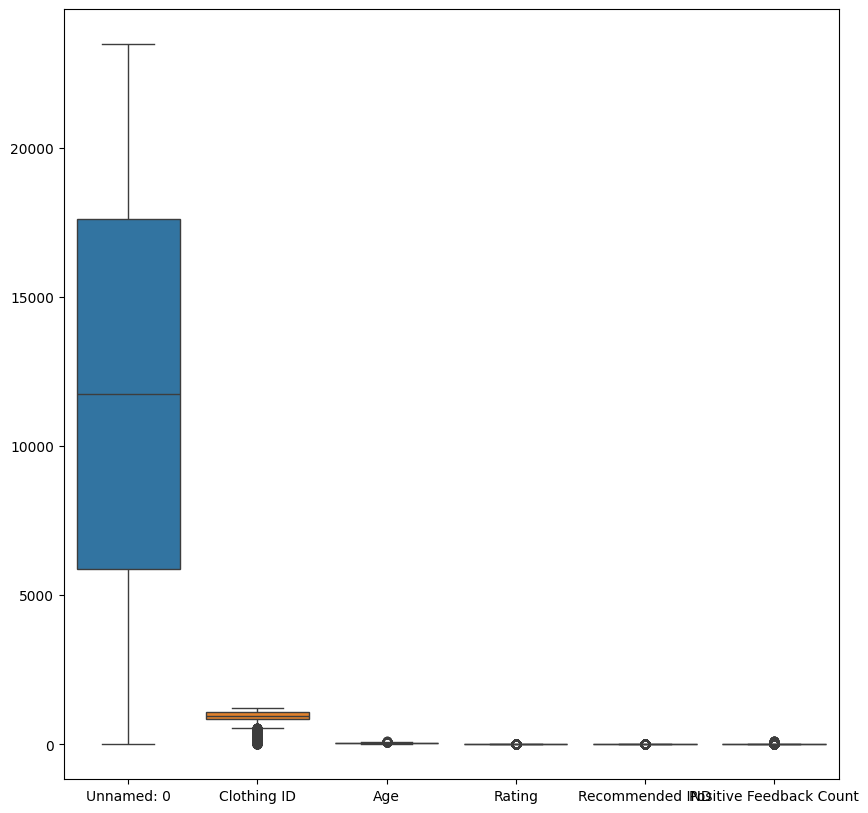

In [7]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.show()

## Pre-Processing Data

In [22]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

def get_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

df.loc[:, 'Label'] = df['Rating'].apply(get_sentiment)
df.dropna(inplace=True)
df.loc[:, 'Label'] = df['Label'].astype(int)

In [23]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['Review Text'] = df['Review Text'].apply(clean_text)
df = df[df['Review Text'].str.strip() != '']

In [24]:
X = df['Review Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

## RNN Model

###Recurrent Neural Network (RNN)

Pada RNN, hidden state diperbarui menggunakan input saat ini dan hidden state sebelumnya:

$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$

Output (jika digunakan secara langsung):

$$
y_t = W_{hy} h_t + b_y
$$

In [27]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(name='auc')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
history = model.fit(X_train_pad, y_train,
                    validation_data=(X_test_pad, y_test),
                    epochs=10,
                    batch_size=128,
                    class_weight=class_weights)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.5138 - auc: 0.5237 - loss: 0.7423 - precision: 0.8880 - recall: 0.5110 - val_accuracy: 0.5387 - val_auc: 0.7356 - val_loss: 0.6907 - val_precision: 0.9492 - val_recall: 0.5013
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7231 - auc: 0.8061 - loss: 0.5236 - precision: 0.9542 - recall: 0.7217 - val_accuracy: 0.8355 - val_auc: 0.9146 - val_loss: 0.3886 - val_precision: 0.9748 - val_recall: 0.8341
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8922 - auc: 0.9645 - loss: 0.2523 - precision: 0.9876 - recall: 0.8881 - val_accuracy: 0.9192 - val_auc: 0.9309 - val_loss: 0.2227 - val_precision: 0.9613 - val_recall: 0.9460
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9534 - auc: 0.9899 - loss: 0.1266 - precision: 0.9949 - recall: 0.9520 - val_accuracy: 0.7840 - val_auc: 0.9223 - val_loss: 0.5487 - val_precision: 0.9843 - val_recall: 0.7662
Epoch 5/10
108/108 ━━━━━━━

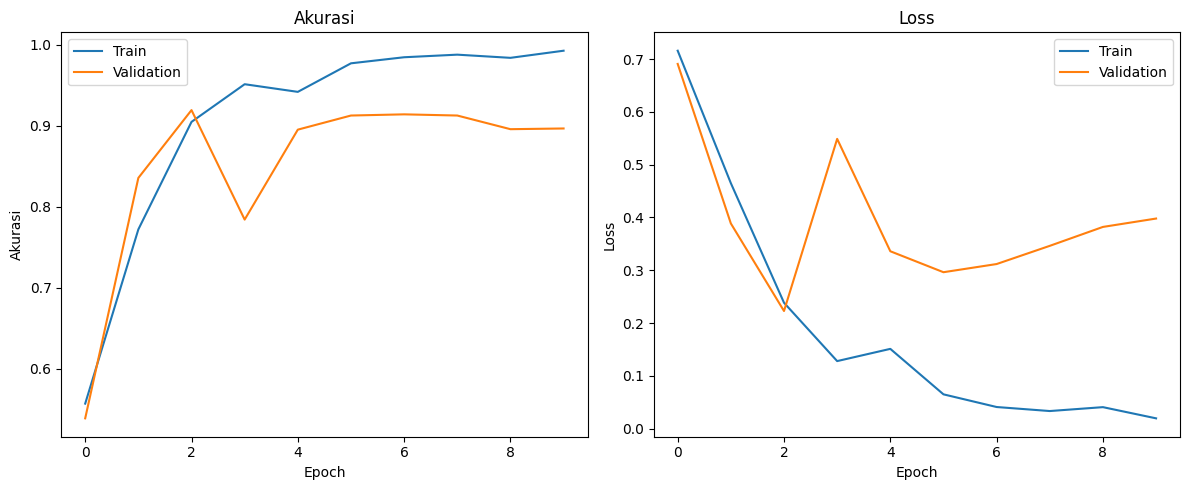

In [29]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
y_pred_prob = model.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Akurasi: 0.8965
Presisi: 0.9555
Recall: 0.9252
F1-Score: 0.9401
AUC: 0.8988


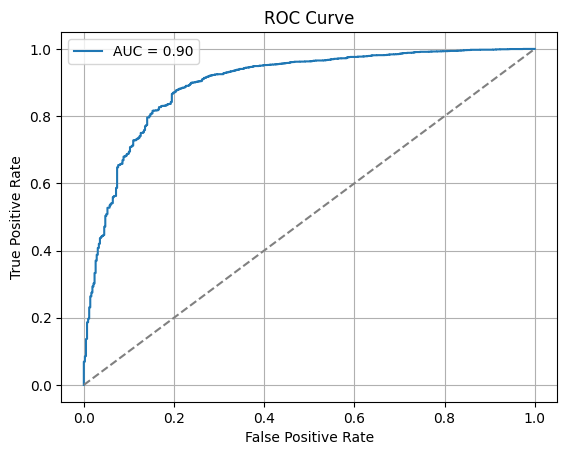

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## LSTM Model

###Long Short-Term Memory (LSTM)

LSTM memiliki 3 gerbang utama: **Forget Gate**, **Input Gate**, dan **Output Gate**.

- **Forget Gate:**
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

- **Input Gate:**
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

- **Cell State Update:**
$$
C_t = f_t * C_{t-1} + i_t * \tilde{C}_t
$$

- **Output Gate:**
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t * \tanh(C_t)
$$

In [37]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(64, return_sequences=True))  # LSTM layer pertama
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))  # LSTM layer kedua
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_lstm.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy',
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.AUC(name='auc')])

In [38]:
history_lstm = model_lstm.fit(X_train_pad, y_train,
                              validation_data=(X_test_pad, y_test),
                              epochs=10,
                              batch_size=128,
                              class_weight=class_weights)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8008 - auc: 0.7391 - loss: 0.5746 - precision_1: 0.9284 - recall_1: 0.8409 - val_accuracy: 0.8674 - val_auc: 0.9514 - val_loss: 0.3231 - val_precision_1: 0.9863 - val_recall_1: 0.8609
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9099 - auc: 0.9635 - loss: 0.2420 - precision_1: 0.9879 - recall_1: 0.9084 - val_accuracy: 0.8128 - val_auc: 0.9555 - val_loss: 0.4314 - val_precision_1: 0.9925 - val_recall_1: 0.7927
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9267 - auc: 0.9801 - loss: 0.1737 - precision_1: 0.9944 - recall_1: 0.9226 - val_accuracy: 0.9169 - val_auc: 0.9540 - val_loss: 0.2085 - val_precision_1: 0.9737 - val_recall_1: 0.9305
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9530 - auc: 0.9894 - loss: 0.1193 - precision_1: 0.9968 - recall_1: 0.9497 - val_accuracy: 0.9081 - val_auc: 0.9540 - val_loss: 0.2477 - val_precision_1: 0.9771 - val_recall_1: 0.

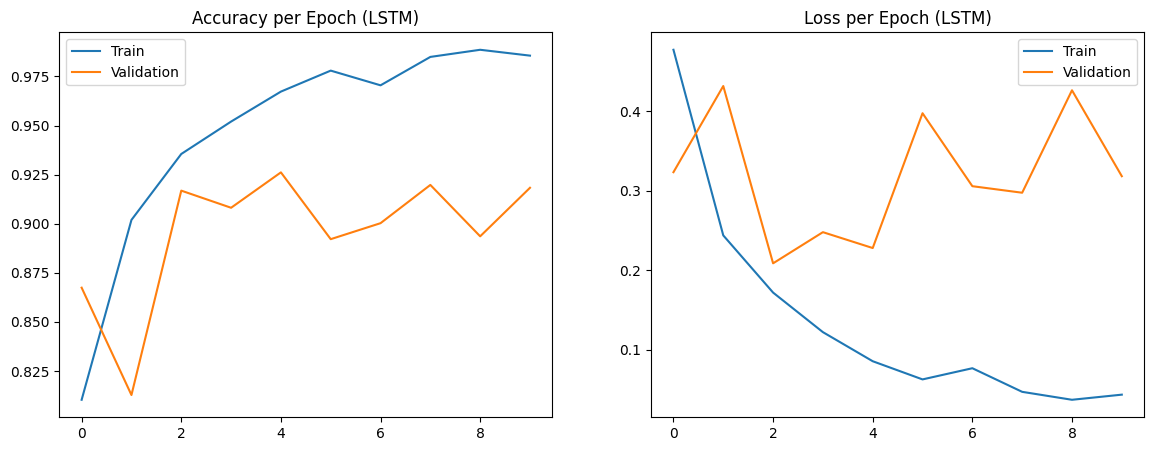

In [40]:
plt.figure(figsize=(14,5))

# Plot Akurasi
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch (LSTM)')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('Loss per Epoch (LSTM)')
plt.legend()
plt.show()

In [43]:
y_pred_lstm_prob = model_lstm.predict(X_test_pad).flatten()
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm)
rec = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_lstm_prob)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Akurasi: 0.9183
Presisi: 0.9548
Recall: 0.9520
F1-Score: 0.9401
AUC: 0.9347


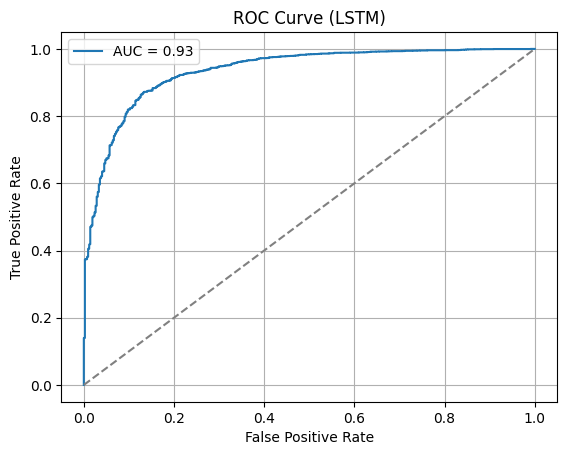

In [44]:
# ROC Curve untuk LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_lstm_prob)
plt.plot(fpr_lstm, tpr_lstm, label=f'AUC = {auc_score_lstm:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC Curve (LSTM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## GRU Model

### Gated Recurrent Unit (GRU)

GRU menyederhanakan LSTM dengan dua gerbang: **Update Gate** dan **Reset Gate**.

- **Update Gate:**
$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

- **Reset Gate:**
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

- **Candidate Activation:**
$$
\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
$$

- **Final Hidden State:**
$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

In [45]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model_gru.add(GRU(64, return_sequences=True))  # GRU layer pertama
model_gru.add(Dropout(0.5))
model_gru.add(GRU(32))  # GRU layer kedua
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

# Compile model GRU
model_gru.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC(name='auc')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
history_gru = model_gru.fit(X_train_pad, y_train,
                            validation_data=(X_test_pad, y_test),
                            epochs=10,
                            batch_size=128,
                            class_weight=class_weights)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6723 - auc: 0.6831 - loss: 0.6331 - precision_2: 0.9192 - recall_2: 0.6868 - val_accuracy: 0.8509 - val_auc: 0.9233 - val_loss: 0.3505 - val_precision_2: 0.9793 - val_recall_2: 0.8480
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8816 - auc: 0.9509 - loss: 0.2800 - precision_2: 0.9860 - recall_2: 0.8784 - val_accuracy: 0.9166 - val_auc: 0.9449 - val_loss: 0.2157 - val_precision_2: 0.9685 - val_recall_2: 0.9354
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9333 - auc: 0.9813 - loss: 0.1739 - precision_2: 0.9915 - recall_2: 0.9318 - val_accuracy: 0.9209 - val_auc: 0.9566 - val_loss: 0.2140 - val_precision_2: 0.9771 - val_recall_2: 0.9318
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9574 - auc: 0.9914 - loss: 0.1027 - precision_2: 0.9961 - recall_2: 0.9554 - val_accuracy: 0.9172 - val_auc: 0.9462 - val_loss: 0.2229 - val_precision_2: 0.9743 - val_recall_2: 0.9

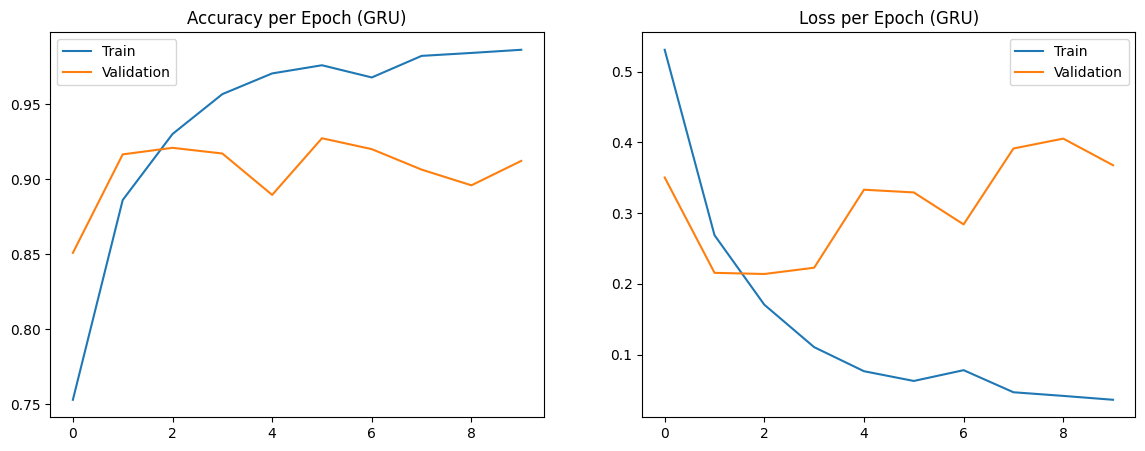

In [47]:
plt.figure(figsize=(14,5))

# Akurasi
plt.subplot(1,2,1)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch (GRU)')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title('Loss per Epoch (GRU)')
plt.legend()
plt.show()

In [50]:
y_pred_gru_prob = model_gru.predict(X_test_pad).flatten()
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_gru)
prec = precision_score(y_test, y_pred_gru)
rec = recall_score(y_test, y_pred_gru)
f1 = f1_score(y_test, y_pred)
auc_score_gru = roc_auc_score(y_test, y_pred_gru_prob)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc_score_gru:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Akurasi: 0.9122
Presisi: 0.9651
Recall: 0.9338
F1-Score: 0.9401
AUC: 0.9368


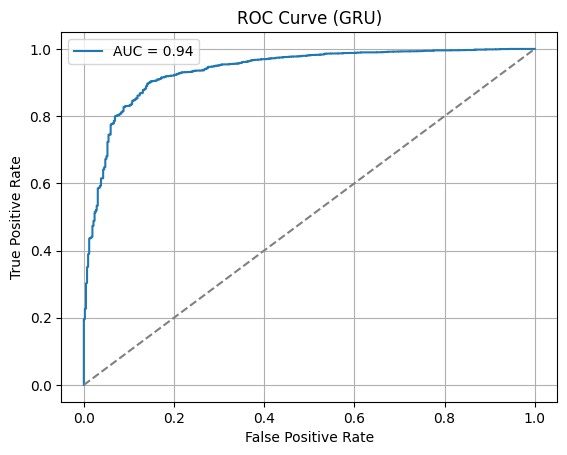

In [51]:
fpr_gru, tpr_gru, _ = roc_curve(y_test, y_pred_gru_prob)
plt.plot(fpr_gru, tpr_gru, label=f'AUC = {auc_score_gru:.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title('ROC Curve (GRU)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## Metrik Evaluasi


###Accuracy
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

---

###Precision
$$
Precision = \frac{TP}{TP + FP}
$$

---

###Recall
$$
Recall = \frac{TP}{TP + FN}
$$

---

###F1-Score
$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

---

###AUC (Area Under Curve)
AUC mengukur area di bawah kurva **ROC (Receiver Operating Characteristic)**.

- ROC adalah plot **True Positive Rate (TPR)** vs **False Positive Rate (FPR)**:

$$
TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
$$

## **Persamaan Matematis dan Teknik Tambahan untuk Meningkatkan Performa Model**

---

### 1. Dropout

**Dropout** adalah teknik regularisasi yang secara acak “menghapus” neuron selama training untuk mencegah overfitting.

- Misal \( z \) adalah output neuron sebelum dropout:
$$
\tilde{z} = z \cdot r
$$

- Di mana:
  - \( r \sim \text{Bernoulli}(p) \)
  - \( p \) adalah probabilitas untuk mempertahankan neuron
  - Pada inference (testing), dropout tidak diterapkan, dan output biasanya dikalikan \( p \) agar tetap seimbang

---

### 2. Early Stopping

**Early Stopping** adalah teknik untuk menghentikan training jika validasi tidak membaik setelah beberapa epoch.

- Misal:
  - \( L_{val}^{(t)} \): loss validasi pada epoch ke-\( t \)
  - Stop training jika:
$$
L_{val}^{(t)} > L_{val}^{(t - patience)}
$$

- Dengan kata lain, model berhenti jika loss validasi tidak membaik setelah sejumlah epoch tertentu (patience).

---

### 3. Regularisasi L2 (Weight Decay)

**L2 Regularization** menambahkan penalti terhadap bobot besar agar model tidak terlalu kompleks:

- Total loss:
$$
L_{total} = L_{data} + \lambda \sum_{i} w_i^2
$$

- Di mana:
  - \( L_{data} \): loss asli (seperti cross-entropy)
  - \( \lambda \): koefisien regularisasi (semakin besar, semakin kuat penalti)
  - \( w_i \): bobot parameter model

---

### 4. Learning Rate Scheduler

**Learning Rate Scheduler** menyesuaikan laju belajar selama training untuk stabilitas dan konvergensi cepat.

- Contoh Exponential Decay:
$$
\eta_t = \eta_0 \cdot e^{-\lambda t}
$$

- Di mana:
  - \( \eta_0 \): learning rate awal
  - \( \eta_t \): learning rate di epoch ke-\( t \)
  - \( \lambda \): decay rate

---

### 5. Bidirectional RNN (LSTM/GRU)

Menggabungkan dua arah pemrosesan:
- Forward: dari \( t = 1 \to T \)
- Backward: dari \( t = T \to 1 \)

- Output gabungan:
$$
\overrightarrow{h_t}, \ \overleftarrow{h_t} \Rightarrow h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]
$$

Gabungan ini memperkaya konteks karena model melihat input dari dua arah.

---

### 6. Pretrained Word Embedding (Word2Vec, GloVe)

Representasi kata berbasis vektor:

- Misal dua kata \( w_i \) dan \( w_j \), maka:
$$
\text{cosine\_similarity}(w_i, w_j) = \frac{w_i \cdot w_j}{\|w_i\| \|w_j\|}
$$

- Embedding pretrained bisa digunakan dengan layer `Embedding` agar representasi lebih kuat sejak awal training.

---

